In [1]:
import sys

import torch  # noqa: E402
import random  # noqa: E402
import numpy as np  # noqa: E402
import matplotlib.pyplot as plt
import ot
import importlib

from pydil.utils.Online_GMM import Online_GMM

from pydil.ipms.ot_ipms import (  # noqa: E402
    JointWassersteinDistance
)
from pydil.dadil.labeled_dictionary import LabeledDictionary  # noqa: E402
from pydil.dadil.labeled_dictionary_GMM import LabeledDictionaryGMM
from pydil.ot_utils.barycenters import wasserstein_barycenter  # noqa: E402
from pydil.torch_utils.measures import (  # noqa: E402
    UnsupervisedDatasetMeasure,
    SupervisedDatasetMeasure
)

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture

C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ot\backend.py:2998: UserWarning: To use TensorflowBackend, you need to activate the tensorflow numpy API. You can activate it by running: 
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
  register_backend(TensorflowBackend())
C:\Users\SL276123\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = np.load(r'C:\Users\SL276123\Documents\Online DaDiL\CSTR\data\cstr_acfmeandata.npy')

In [44]:
dataset.shape

(2860, 18)

In [45]:
X = dataset[:, :-4]
y = dataset[:, -4]
d = dataset[:, -3]

n_domains = int(np.max(d)) + 1
n_features = X.shape[1]

In [46]:
X.shape, y.shape, d.shape

((2860, 14), (2860,), (2860,))

In [47]:
Xs, ys = [], []
for i in range(n_domains-1):
    Xs.append(torch.from_numpy(X[np.where(d == i)[0]]).float())
    ys.append(torch.from_numpy(y[np.where(d == i)[0]]).float())

In [48]:
Xt = torch.from_numpy(X[np.where(d == n_domains-1)[0]]).float()
yt = torch.from_numpy(y[np.where(d == n_domains-1)[0]]).float()

In [49]:
combined_arrays = list(zip(Xt, yt))

# Shuffle the combined arrays
random.shuffle(combined_arrays)

# Unzip the shuffled arrays back into separate arrays
Xt, yt = zip(*combined_arrays)
Xt = torch.stack(Xt, axis=0)
yt = torch.stack(yt, axis=0)

In [50]:
n_samples = 1300
batch_size = 260
n_components = 3

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train_t = torch.from_numpy(X_train)
X_test_t = torch.from_numpy(X_test)
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(X[np.where(d==6)[0], :], y[np.where(d==6)[0]], test_size=0.2, random_state=0)
X_train_target_t = torch.from_numpy(X_train_target)
X_test_target_t = torch.from_numpy(X_test_target)
dim_reduction = 3

In [52]:
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

dim_reduction = 3
K_max = 13
OGMM = Online_GMM(
    n_components=K_max, 
    lr=0.1,
    n_features=dim_reduction,
    data_range=range_data,
    batch_size=batch_size
)

i=0
while i < Xt.shape[0]-dim_reduction:
    OGMM.fit_sample(Xt[i:i+dim_reduction, :], dimension_reduction=True)
    i += dim_reduction

In [53]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)

GaussianMixture(n_components=13, random_state=0)

## Tests on the GMM

In [62]:
np.sum(OGMM.score_samples(Xt, dimension_reduction=True))

30.59109922233118

In [63]:
sklearn_GMM = GaussianMixture(n_components=K_max, random_state=0)
sklearn_GMM.fit(Xt)
np.sum(sklearn_GMM.score_samples(Xt))

14069.064587801055

(0.0, 1.0, 0.0, 1.0)

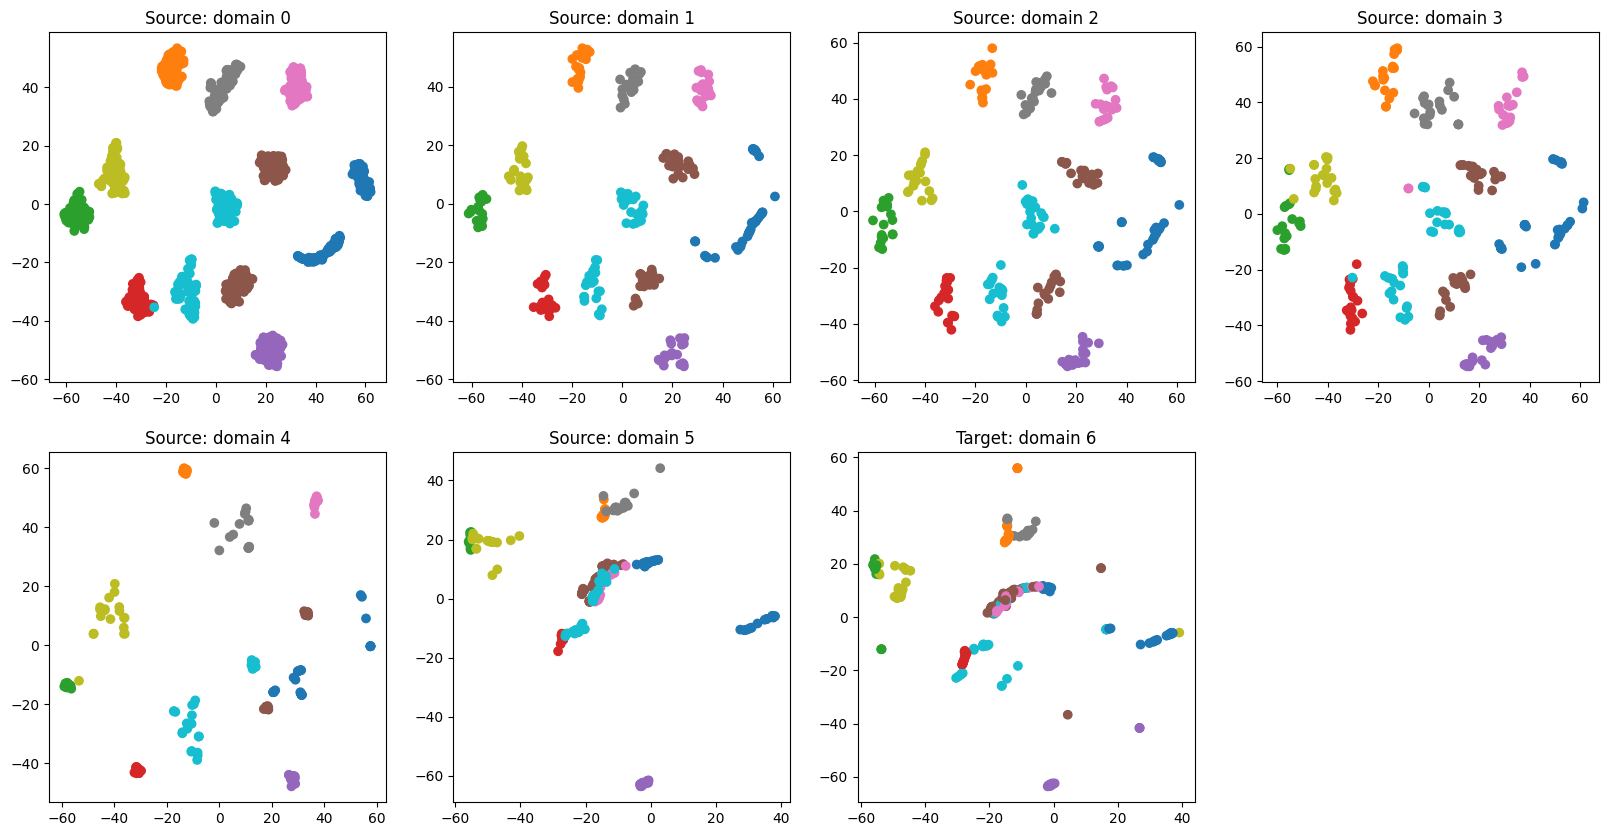

In [64]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [Xt], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-1]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys + [yt], dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
        
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

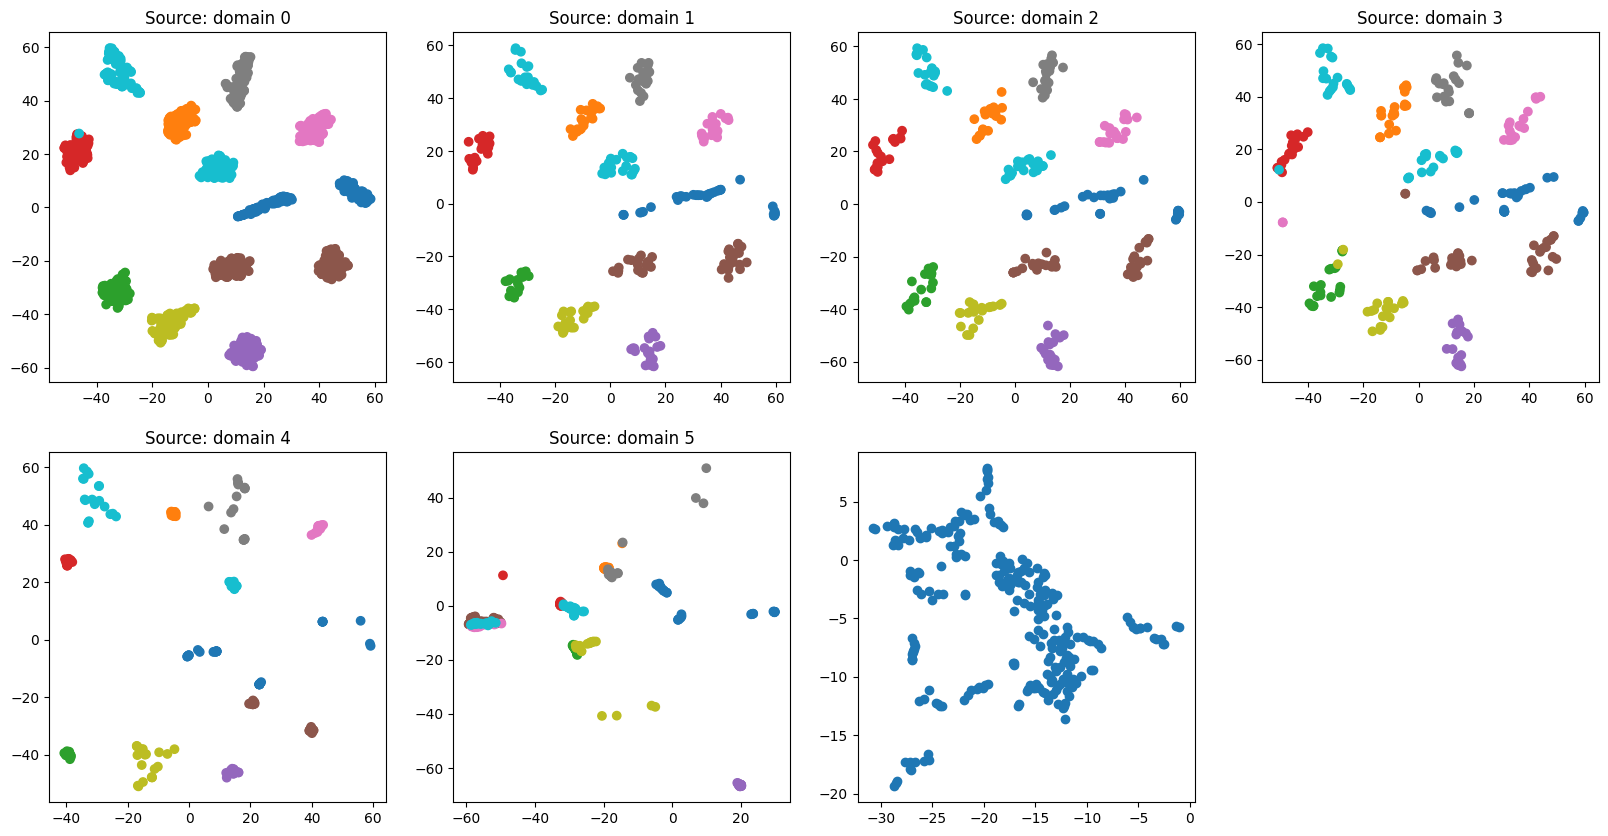

In [65]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [OGMM.sample(260)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.0, 1.0)

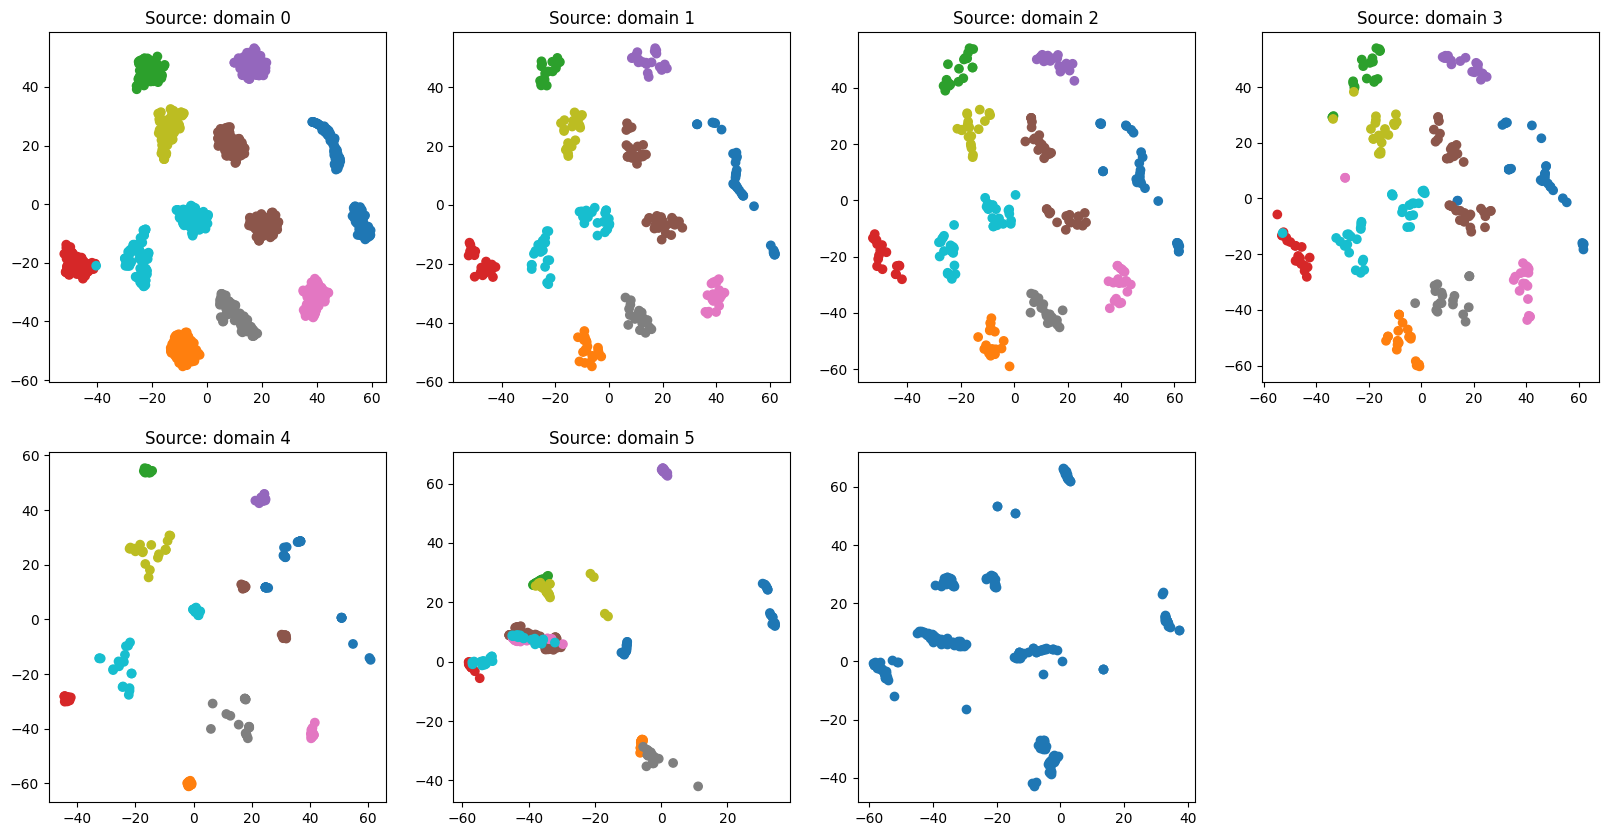

In [66]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [torch.from_numpy(sklearn_GMM.sample(260)[0]).float()], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

Test to determine the best K_max

In [16]:
%%script false --no-exec
range_data = np.mean(np.max(X[np.where(d!=6)[0], :], axis=0) - np.min(X[np.where(d!=6)[0], :], axis=0))

K_max = np.linspace(13, 63, 11)
ll = []
for kmax in K_max:
    OGMM = Online_GMM(
        n_components=kmax, 
        lr=0.1,
        n_features=dim_reduction,
        data_range=range_data,
        batch_size=batch_size
    )
    
    i = 0
    while i < X_train_target_t.shape[0]-dim_reduction:
        OGMM.fit_sample(X_train_target_t[i:i+dim_reduction, :], dimension_reduction=True)
        i += dim_reduction

    print(OGMM.generate_list())
    ll.append(OGMM.log_likelihood(X_test_target_t, dimension_reduction=True))

Couldn't find program: 'false'


## Dictionary learning seperated between sources and target with Online_GMM simultaneously

In [67]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )

In [68]:
criterion = JointWassersteinDistance()

In [69]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [70]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 106.35753936767578
It 2/40, Loss: 48.27917251586914
It 3/40, Loss: 21.349705696105957
It 4/40, Loss: 9.229718685150146
It 5/40, Loss: 4.758793735504151
It 6/40, Loss: 2.770534086227417
It 7/40, Loss: 1.8800439596176148
It 8/40, Loss: 1.3594886302947997
It 9/40, Loss: 1.0371120929718018
It 10/40, Loss: 0.838847315311432
It 11/40, Loss: 0.7196658372879028
It 12/40, Loss: 0.6436766862869262
It 13/40, Loss: 0.5876207590103149
It 14/40, Loss: 0.5423047423362732
It 15/40, Loss: 0.518286383152008
It 16/40, Loss: 0.4974715828895569
It 17/40, Loss: 0.48627451658248905
It 18/40, Loss: 0.4587927103042602
It 19/40, Loss: 0.442953634262085
It 20/40, Loss: 0.41360635161399845
It 21/40, Loss: 0.3815447330474854
It 22/40, Loss: 0.34020161628723145
It 23/40, Loss: 0.3003350496292114
It 24/40, Loss: 0.26094791889190677
It 25/40, Loss: 0.23819895088672638
It 26/40, Loss: 0.21264469027519226
It 27/40, Loss: 0.20848849117755888
It 28/40, Loss: 0.20677529871463773
It 29/40, Loss: 0.1939942508

In [71]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [72]:
names_sources = [f'domain {i}' for i in range(6)]

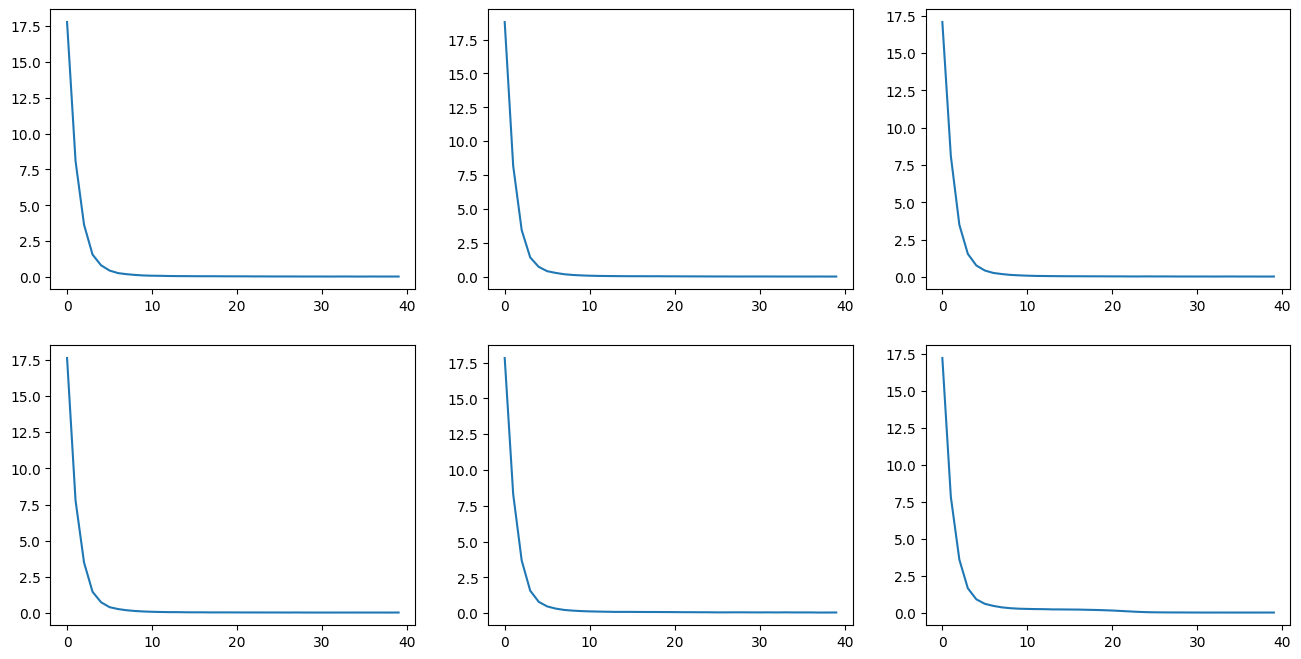

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

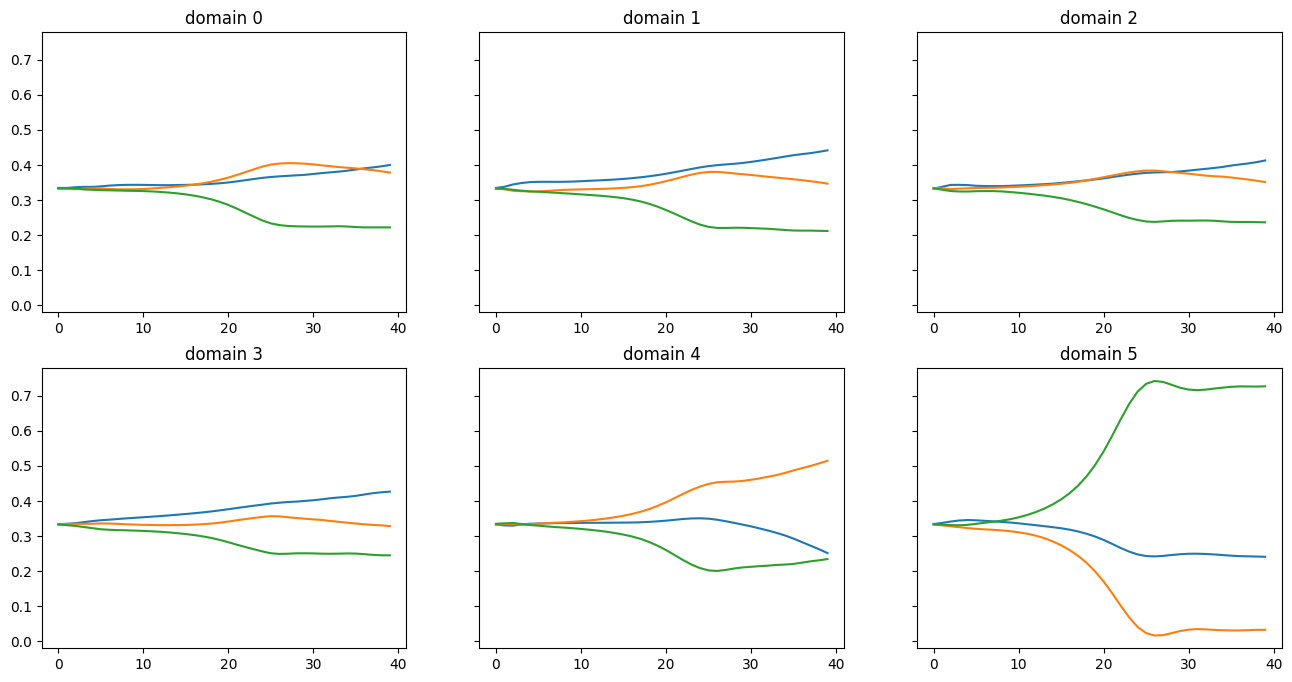

In [74]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [75]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=1,
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False,
                           GMM_components=13,
                           GMM_dim_reduction=dim_reduction)

In [76]:
i = 0
while i < Xt.shape[0]-dim_reduction:
    print(i)
    dictionary_target.fit_target_sample(Xt[i:i+dim_reduction, :],
                                        batches_per_it=n_samples // batch_size,
                                        batch_size=batch_size,
                                        verbose=True,
                                        regularization=False,)
    i += dim_reduction

0
Loss: 0.4356770515441894
3
Loss: 0.29258158802986145
6
Loss: 0.283815598487854
9
Loss: 0.28141826987266544
12
Loss: 0.2869372725486755
15
Loss: 0.22149518132209778
18
Loss: 0.2872299373149872
21
Loss: 0.3084922909736633
24
Loss: 0.29281690120697024
27
Loss: 0.2024231344461441
30
Loss: 0.16004966795444486
33
Loss: 0.1276009976863861
36
Loss: 0.15808467566967008
39
Loss: 0.16493043005466462
42
Loss: 0.16591844558715818
45
Loss: 0.14393469989299773
48
Loss: 0.14072152078151703
51
Loss: 0.16966522634029388
54
Loss: 0.15202924907207488
57
Loss: 0.13752985000610352
60
Loss: 0.1315494328737259
63
Loss: 0.12316657155752184
66
Loss: 0.11567196398973466
69
Loss: 0.1055029347538948
72
Loss: 0.11335406899452208
75
Loss: 0.1274888813495636
78
Loss: 0.12302203178405761
81
Loss: 0.1117641732096672
84
Loss: 0.11691025048494338
87
Loss: 0.12127208709716795
90
Loss: 0.12959224879741668
93
Loss: 0.1544569730758667
96
Loss: 0.14379070103168487
99
Loss: 0.1393378645181656
102
Loss: 0.17335216104984286
10

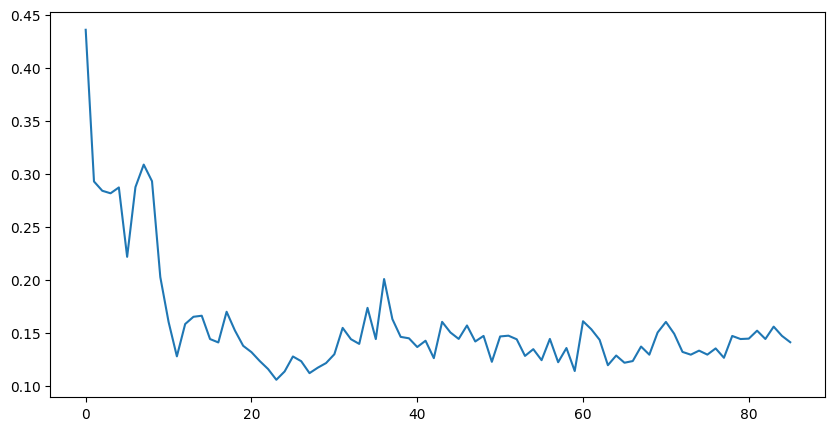

In [77]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'domain 6')

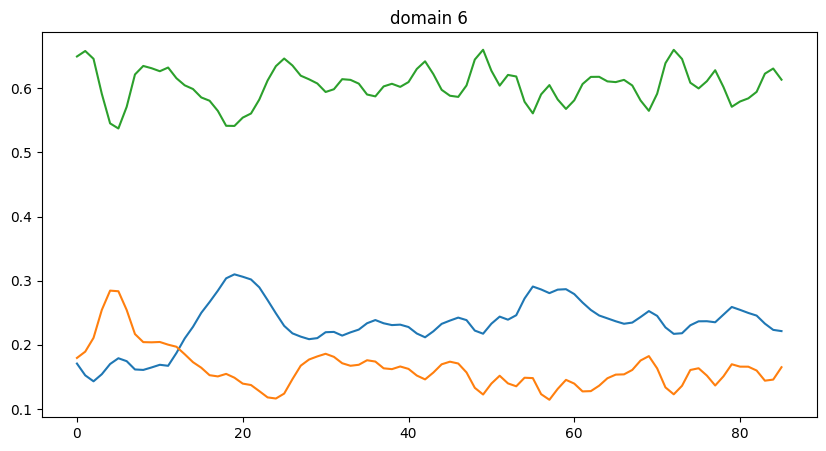

In [86]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

(0.0, 1.0, 0.0, 1.0)

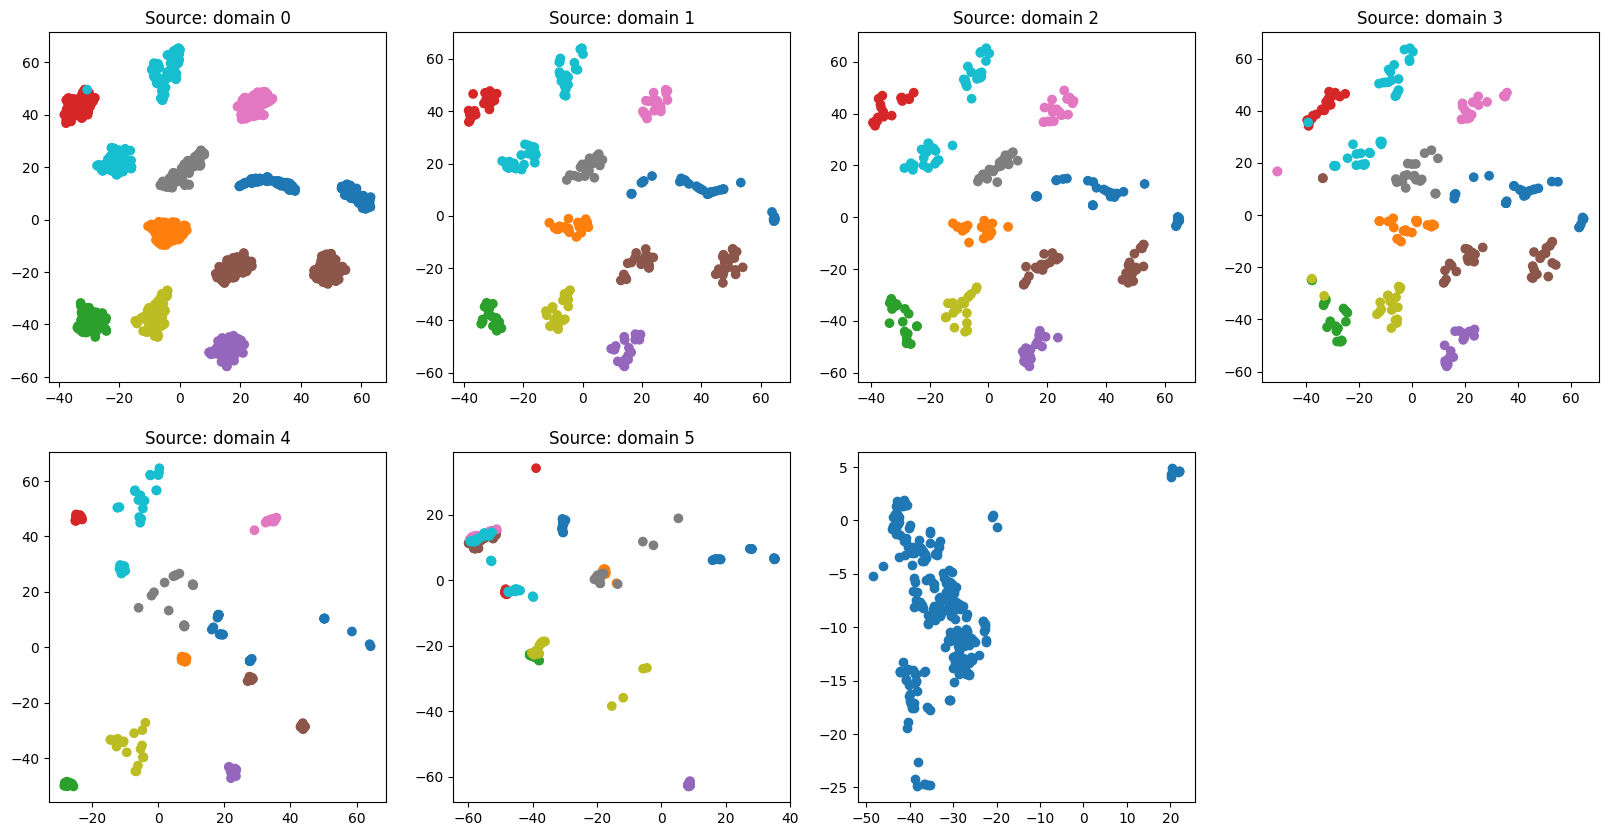

In [79]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(
    torch.cat(Xs + [dictionary_target.OGMM.sample(260)[0]], dim=0)
)
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

markers = ['o', '^', 'P', 'D']
for k, ax in enumerate(axes.flatten()[:-2]):
    ind = np.where(d == k)[0]
    ax.scatter(proj[ind, 0],
               proj[ind, 1],
               c=torch.cat(ys, dim=0)[ind],
               cmap='tab10')
    if names[k] == target_name:
        ax.set_title(f'Target: {names[k]}')
    else:
        ax.set_title(f'Source: {names[k]}')
ind = np.where(d == 6)[0]
axes.flatten()[-2].scatter(proj[ind, 0],
               proj[ind, 1])
axes.flatten()[-1].axis('off')

In [80]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.2215, 0.1653, 0.6132])


In [81]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [83]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8269230769230769


DaDiL-E

In [91]:
clf = SVC(kernel='rbf', probability=True)
clf = RandomForestClassifier(criterion='gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.22200000286102295 got 0.35
Atom 1 w/ weight 0.16500000655651093 got 0.19615384615384615
Atom 2 w/ weight 0.6129999756813049 got 0.6346153846153846
0.6153846153846154


DaDiL-R

In [88]:
clf = SVC(kernel='rbf')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6653846153846154


## Dictionary learning seperated between sources and target

In [54]:
Q_sources = []
for Xs_k, ys_k in zip(Xs, ys):
    Q_sources.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q_target = [OGMM]

Q_sources_and_target = Q_sources + Q_target

In [55]:
criterion = JointWassersteinDistance()

In [56]:
dictionary_sources = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_sources),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [57]:
dictionary_sources.fit(Q_sources,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/40, Loss: 104.57896575927735
It 2/40, Loss: 48.48569030761718
It 3/40, Loss: 20.745359039306642
It 4/40, Loss: 9.587585067749023
It 5/40, Loss: 4.695422554016113
It 6/40, Loss: 2.718421077728271
It 7/40, Loss: 1.870379400253296
It 8/40, Loss: 1.349921202659607
It 9/40, Loss: 1.0536291599273682
It 10/40, Loss: 0.8426506042480469
It 11/40, Loss: 0.6932435393333436
It 12/40, Loss: 0.6030386924743651
It 13/40, Loss: 0.5455300450325012
It 14/40, Loss: 0.5092640280723573
It 15/40, Loss: 0.46095628738403316
It 16/40, Loss: 0.43091865777969357
It 17/40, Loss: 0.39491532444953914
It 18/40, Loss: 0.3542603731155396
It 19/40, Loss: 0.31674467325210576
It 20/40, Loss: 0.26489515900611876
It 21/40, Loss: 0.24053622484207154
It 22/40, Loss: 0.2299456000328064
It 23/40, Loss: 0.21391334533691403
It 24/40, Loss: 0.21284708380699158
It 25/40, Loss: 0.20963108539581296
It 26/40, Loss: 0.2177614390850067
It 27/40, Loss: 0.21479105651378633
It 28/40, Loss: 0.20286512970924375
It 29/40, Loss: 0.214636

In [58]:
XP_sources = dictionary_sources.XP
YP_sources = dictionary_sources.YP

In [59]:
names_sources = [f'domain {i}' for i in range(6)]

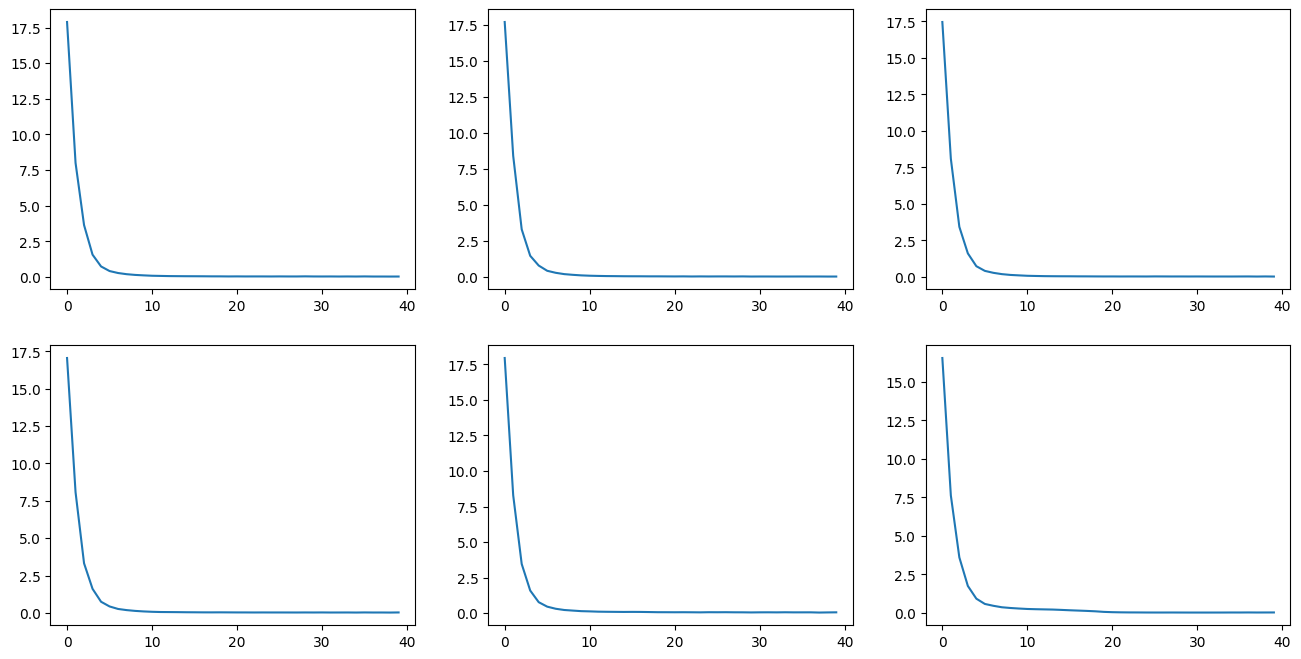

In [60]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
for k, dom in enumerate(dictionary_sources.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary_sources.history['loss_per_dataset'][dom])

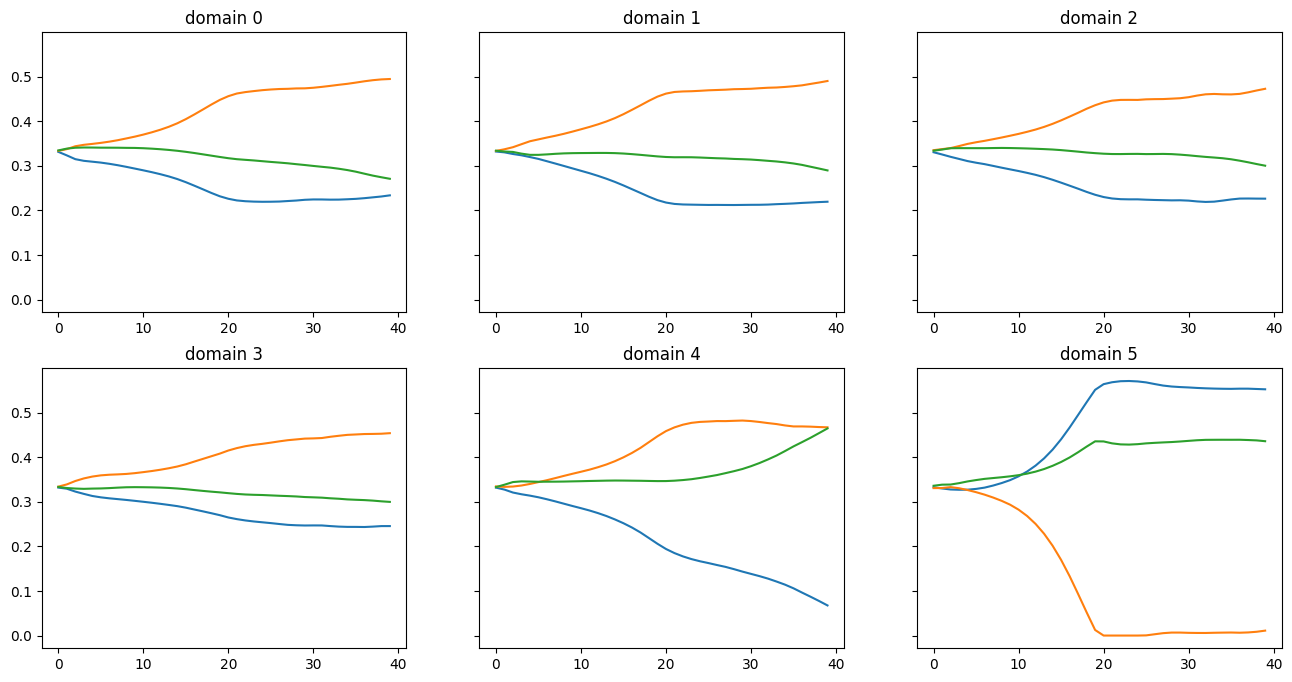

In [61]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names_sources, axes.flatten())):
    ax.plot(torch.stack(dictionary_sources.history['weights'])[:, k, :])
    ax.set_title(name)

In [62]:
dictionary_target = LabeledDictionaryGMM(XP=XP_sources,
                           YP=YP_sources,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q_target),
                           loss_fn=criterion,
                           learning_rate_features=0,
                           learning_rate_labels=0,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [63]:
dictionary_target.fit(Q_target,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               regularization=False)

It 1/40, Loss: 0.16644451022148132
It 2/40, Loss: 0.15179737508296967
It 3/40, Loss: 0.1576697826385498
It 4/40, Loss: 0.15708852708339693
It 5/40, Loss: 0.16109951734542843
It 6/40, Loss: 0.15686920285224912
It 7/40, Loss: 0.15914348065853118
It 8/40, Loss: 0.16173571348190308
It 9/40, Loss: 0.16527546048164368
It 10/40, Loss: 0.15878852307796482
It 11/40, Loss: 0.16121326386928558
It 12/40, Loss: 0.15778304040431976
It 13/40, Loss: 0.15548029243946074
It 14/40, Loss: 0.15469980239868164
It 15/40, Loss: 0.16221418976783752
It 16/40, Loss: 0.16227197349071504
It 17/40, Loss: 0.1584113419055939
It 18/40, Loss: 0.16074424684047697
It 19/40, Loss: 0.15753774940967558
It 20/40, Loss: 0.15285910665988922
It 21/40, Loss: 0.15727139115333558
It 22/40, Loss: 0.16209094524383544
It 23/40, Loss: 0.15863287448883057
It 24/40, Loss: 0.15747550427913667
It 25/40, Loss: 0.16778385639190674
It 26/40, Loss: 0.15736677944660188
It 27/40, Loss: 0.16108661890029907
It 28/40, Loss: 0.16081570088863373
It 

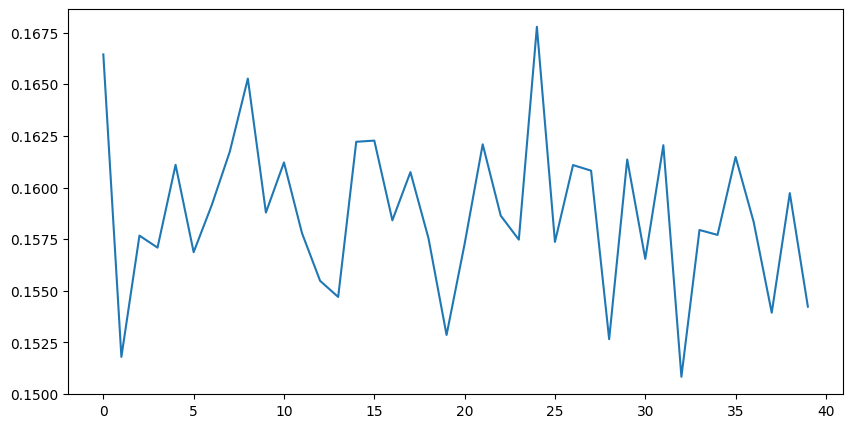

In [64]:
target_name = 'Domain 7'
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(dictionary_target.history['loss_per_dataset']['Domain 0'])

Text(0.5, 1.0, 'Domain 7')

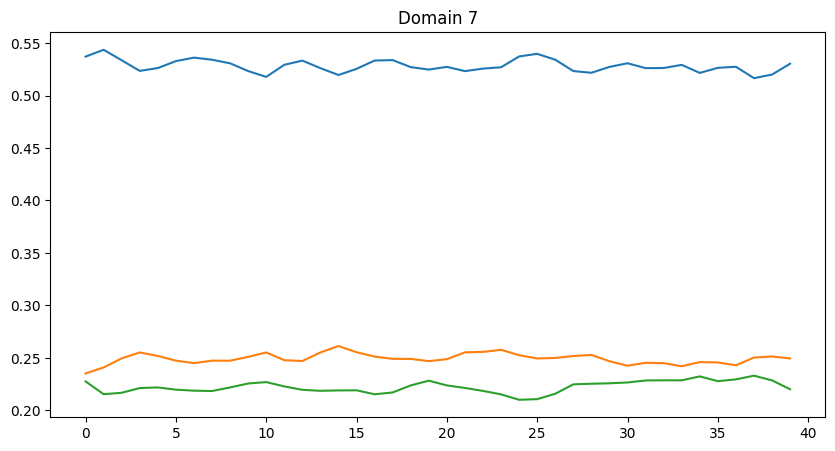

In [65]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(torch.stack(dictionary_target.history['weights'])[:, -1, :])
ax.set_title(target_name)

In [66]:
weights = dictionary_target.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary_target.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary_target.YP]

tensor([0.5303, 0.2495, 0.2202])


In [67]:
Xr, Yr = dictionary_target.reconstruct(weights=weights)

Classification without DA

In [37]:
#clf = SVC(kernel='linear')
clf = RandomForestClassifier(criterion = 'gini')
clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8384615384615385


DaDiL-E

In [83]:
clf = SVC(kernel='rbf', probability=True)
#clf = RandomForestClassifier(criterion = 'gini')

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.5299999713897705 got 0.5576923076923077
Atom 1 w/ weight 0.25 got 0.3769230769230769
Atom 2 w/ weight 0.2199999988079071 got 0.4807692307692308
0.5538461538461539


DaDiL-R

In [81]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion = 'gini')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.6115384615384616


## Classic Dictionary learning with Online_GMM

In [13]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(OGMM)

In [14]:
criterion = JointWassersteinDistance()

In [15]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [16]:
dictionary.fit(Q,
               n_iter_max=40,
               batches_per_it=n_samples // batch_size,
               verbose=True,
               sklearn_GMM=False)

It 1/40, Loss: 107.85574951171876
It 2/40, Loss: 47.187170410156256
It 3/40, Loss: 20.551624298095703
It 4/40, Loss: 8.980498123168944
It 5/40, Loss: 4.689195489883423
It 6/40, Loss: 2.89782075881958
It 7/40, Loss: 2.0714792251586913
It 8/40, Loss: 1.5714067697525023
It 9/40, Loss: 1.2430895805358888
It 10/40, Loss: 1.024754822254181
It 11/40, Loss: 0.9158426284790038
It 12/40, Loss: 0.8316524505615235
It 13/40, Loss: 0.7682775378227233
It 14/40, Loss: 0.7311340808868407
It 15/40, Loss: 0.7148123145103455
It 16/40, Loss: 0.6751349568367004
It 17/40, Loss: 0.6624145746231079
It 18/40, Loss: 0.6393557906150817
It 19/40, Loss: 0.6155221581459045
It 20/40, Loss: 0.5769820690155029
It 21/40, Loss: 0.5320514798164367
It 22/40, Loss: 0.4601393938064575
It 23/40, Loss: 0.39522227644920344
It 24/40, Loss: 0.3440509557723999
It 25/40, Loss: 0.3280439496040344
It 26/40, Loss: 0.3031338512897492
It 27/40, Loss: 0.2854048013687134
It 28/40, Loss: 0.2784614682197571
It 29/40, Loss: 0.274653828144073

In [17]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

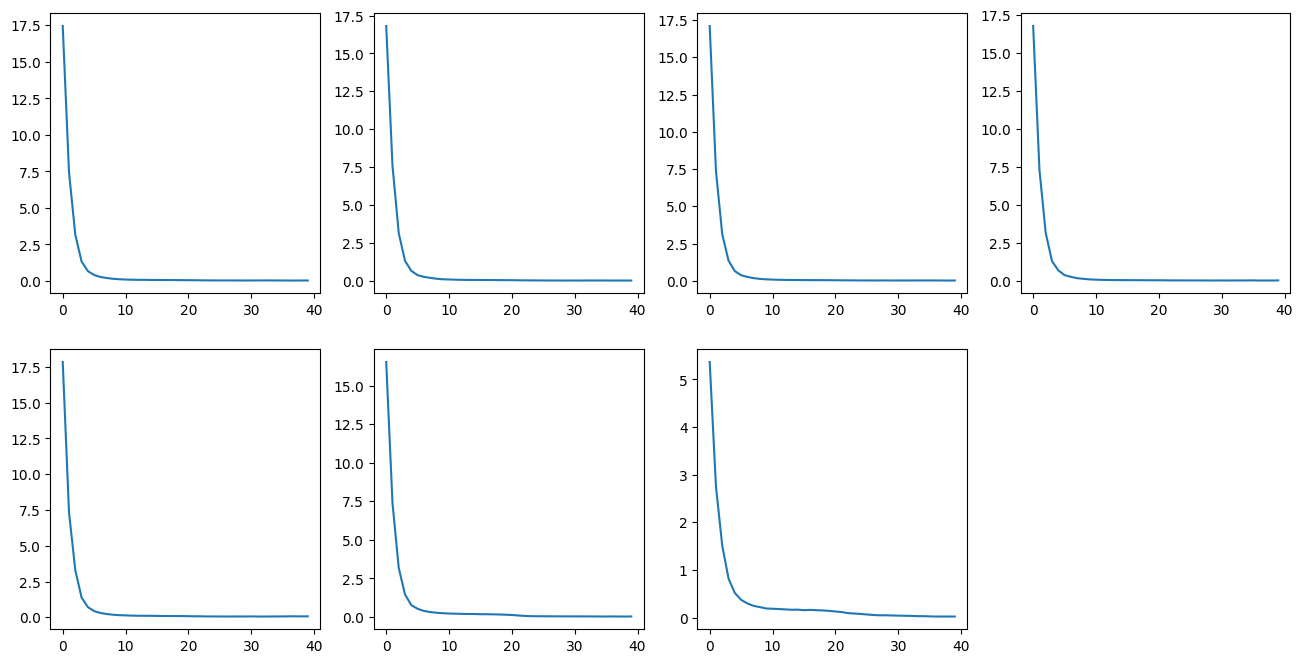

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, -0.034476226568222045, 0.7240007579326629)

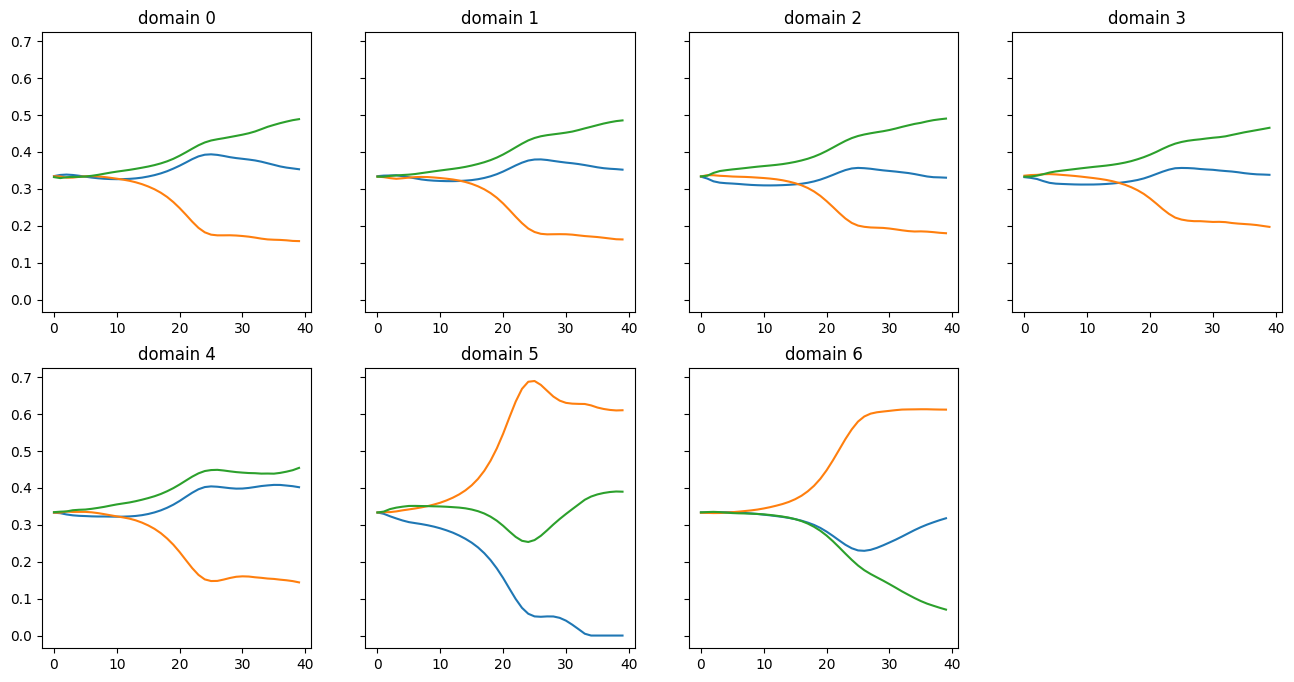

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [20]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.3177, 0.6120, 0.0702])


In [36]:
Xr, Yr = dictionary.reconstruct(weights=weights)

Classification without DA

In [22]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8153846153846154


DaDiL-E

In [39]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.3179999887943268 got 0.2
Atom 1 w/ weight 0.6119999885559082 got 0.49230769230769234
Atom 2 w/ weight 0.07000000029802322 got 0.5653846153846154
0.4115384615384615


DaDiL-R

In [40]:
clf = SVC(kernel='linear')
#clf = RandomForestClassifier()

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.5538461538461539


Final optimal transport to adapt domains

In [35]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    Xt_OGMM = OGMM.sample(XP_k.shape[0])[0]

    weights_k = torch.ones(XP_k.shape[0])/XP_k.shape[0]
    weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

    C = torch.cdist(XP_k, Xt_OGMM, p=2) ** 2
    ot_plan = ot.emd(weights_k, weights_ogmm, C, numItermax=1000000)
    Yt_OGMM = ot_plan.T @ YP_k

    yt_ogmm = Yt_OGMM.argmax(dim=1)
    
    clf.fit(Xt_OGMM, yt_ogmm)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.3179999887943268 got 0.34615384615384615
Atom 1 w/ weight 0.6119999885559082 got 0.48846153846153845
Atom 2 w/ weight 0.07000000029802322 got 0.5115384615384615
0.4346153846153846


In [41]:
Xt_OGMM = OGMM.sample(Xr.shape[0])[0]

weights_r = torch.ones(Xr.shape[0])/Xr.shape[0]
weights_ogmm = torch.ones(Xt_OGMM.shape[0])/Xt_OGMM.shape[0]

C = torch.cdist(Xr, Xt_OGMM, p=2) ** 2
ot_plan = ot.emd(weights_r, weights_ogmm, C, numItermax=1000000)
Yt_OGMM = ot_plan.T @ Yr

clf = SVC(kernel='linear')
#clf = RandomForestClassifier(criterion='gini')

clf.fit(Xt_OGMM, Yt_OGMM.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.46923076923076923


## Classic Dictionary Learning

In [13]:
Q = []
for Xs_k, ys_k in zip(Xs, ys):
    Q.append(
        SupervisedDatasetMeasure(
            features=Xs_k.numpy(),
            labels=ys_k.numpy(),
            stratify=True,
            batch_size=batch_size,
            device='cpu'
        )
    )
    
Q.append(
    UnsupervisedDatasetMeasure(
        features=Xt.numpy(),
        batch_size=batch_size,
        device='cpu'
    )
)

In [14]:
criterion = JointWassersteinDistance()

In [15]:
dictionary = LabeledDictionaryGMM(XP=None,
                           YP=None,
                           A=None,
                           n_samples=n_samples,
                           n_dim=X.shape[1],
                           n_classes=13,
                           n_components=n_components,
                           weight_initialization='uniform',
                           n_distributions=len(Q),
                           loss_fn=criterion,
                           learning_rate_features=1e-1,
                           learning_rate_labels=1e-1,
                           learning_rate_weights=1e-1,
                           reg_e=0.0,
                           n_iter_barycenter=10,
                           n_iter_sinkhorn=20,
                           n_iter_emd=1000000,
                           domain_names=None,
                           grad_labels=True,
                           optimizer_name='Adam',
                           balanced_sampling=True,
                           sampling_with_replacement=True,
                           barycenter_tol=1e-9,
                           barycenter_beta=None,
                           tensor_dtype=torch.float32,
                           track_atoms=False,
                           schedule_lr=False)

In [16]:
dictionary.fit(Q,
               n_iter_max=60,
               batches_per_it=n_samples // batch_size,
               verbose=True)

It 1/60, Loss: 106.3423797607422
It 2/60, Loss: 48.070806121826166
It 3/60, Loss: 20.678227996826173
It 4/60, Loss: 9.285503673553468
It 5/60, Loss: 4.748308563232422
It 6/60, Loss: 2.865239715576172
It 7/60, Loss: 2.0727163553237915
It 8/60, Loss: 1.537552213668823
It 9/60, Loss: 1.2142271995544434
It 10/60, Loss: 1.0122873783111572
It 11/60, Loss: 0.865707790851593
It 12/60, Loss: 0.7957367658615113
It 13/60, Loss: 0.7346983909606934
It 14/60, Loss: 0.6939870953559876
It 15/60, Loss: 0.6741306781768798
It 16/60, Loss: 0.6584912776947022
It 17/60, Loss: 0.6333697319030762
It 18/60, Loss: 0.6254691362380982
It 19/60, Loss: 0.6122795581817627
It 20/60, Loss: 0.5864691615104676
It 21/60, Loss: 0.5417202711105347
It 22/60, Loss: 0.5093261659145355
It 23/60, Loss: 0.44465949535369875
It 24/60, Loss: 0.3759253084659576
It 25/60, Loss: 0.31462734341621396
It 26/60, Loss: 0.2882290780544281
It 27/60, Loss: 0.2533076643943787
It 28/60, Loss: 0.25117858350276945
It 29/60, Loss: 0.23932412862777

In [17]:
names = [f'domain {i}' for i in range(7)]
target_name = names[-1]

(0.0, 1.0, 0.0, 1.0)

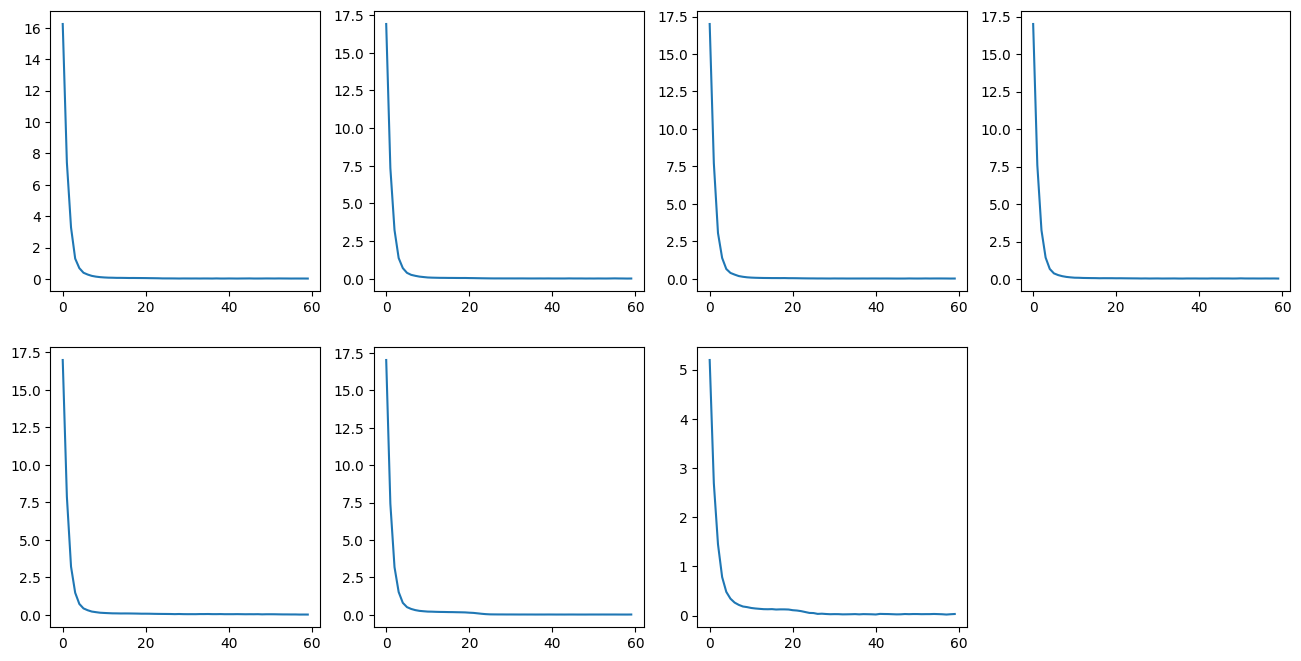

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
for k, dom in enumerate(dictionary.history['loss_per_dataset']):
    axes.flatten()[k].plot(dictionary.history['loss_per_dataset'][dom])
axes.flatten()[-1].axis('off')

(0.0, 1.0, 0.09289187900722026, 0.7199628207832575)

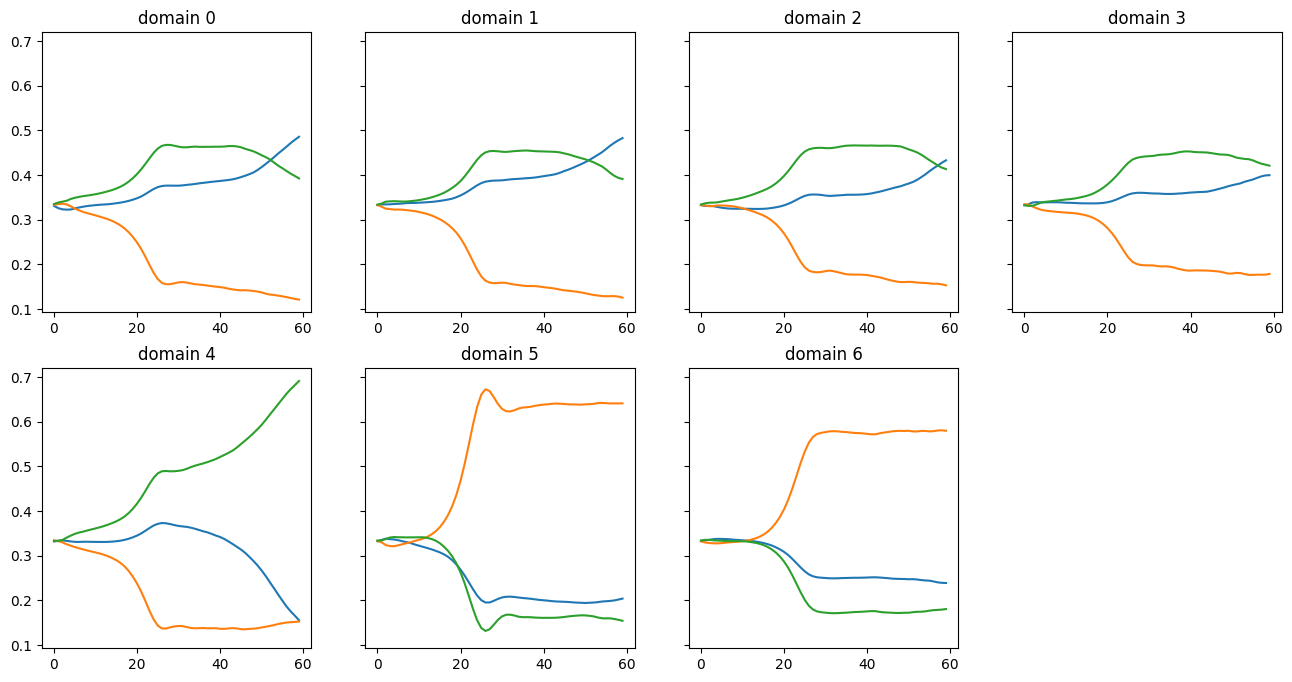

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=True)

for k, (name, ax) in enumerate(zip(names, axes.flatten())):
    ax.plot(torch.stack(dictionary.history['weights'])[:, k, :])
    ax.set_title(name)
axes.flatten()[-1].axis('off')

In [20]:
weights = dictionary.A[-1, :].detach()
print(weights)
XP = [XPk.detach().clone() for XPk in dictionary.XP]
YP = [YPk.detach().clone().softmax(dim=-1) for YPk in dictionary.YP]

tensor([0.2391, 0.5802, 0.1808])


In [21]:
Xr, Yr = wasserstein_barycenter(
    XP=XP,
    YP=YP,
    n_samples=n_samples,
    weights=weights,
    tol=1e-9,
    n_iter_max=10,
    propagate_labels=True,
    penalize_labels=True
)

Classification without DA

In [33]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier()

clf.fit(torch.cat(Xs, dim=0),
        torch.cat(ys, dim=0))
yp = clf.predict(Xt)
print(accuracy_score(yp, yt))

0.8538461538461538


DaDiL-E

In [56]:
clf = SVC(kernel='linear', probability=True)
#clf = RandomForestClassifier()

predictions = []
for k, (XP_k, YP_k) in enumerate(zip(XP, YP)):
    # Get atom data
    XP_k, YP_k = XP_k.data.cpu(), YP_k.data.cpu()
    yp_k = YP_k.argmax(dim=1)
    
    clf.fit(XP_k, yp_k)
    yp = clf.predict(Xt)
    print("Atom {} w/ weight {} got {}".format(k, np.round(weights[k], 3), accuracy_score(yt, yp)))

    P = clf.predict_proba(Xt)
    predictions.append(P)
predictions = np.stack(predictions)

# Weights atomic model predictions
yp = np.einsum('i,inj->nj', weights, predictions).argmax(axis=1)

# Compute statistics
accuracy_e = accuracy_score(yt, yp)
print(accuracy_e)

Atom 0 w/ weight 0.23899999260902405 got 0.4576923076923077
Atom 1 w/ weight 0.5799999833106995 got 0.5461538461538461
Atom 2 w/ weight 0.1809999942779541 got 0.4230769230769231
0.55


DaDiL-R

In [62]:
#clf = SVC(kernel='rbf')
clf = RandomForestClassifier(criterion='entropy')

clf.fit(Xr, Yr.argmax(dim=1))
yp = clf.predict(Xt)
accuracy_r = accuracy_score(yp, yt)
print(accuracy_r)

0.7846153846153846
